In [ ]:
!pip install librosa regex

In [ ]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
!apt-get update
!apt-get install -y ffmpeg

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed

In [ ]:
!ffmpeg -version

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-l

In [ ]:
!pip install ffmpeg-python

# **Initaial imports and checks**

In [ ]:
# Standard library
import os
import time
import io
import glob
import random
import warnings
from base64 import b64decode

# Numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Audio processing
import librosa
import librosa.display
import ffmpeg
from scipy.io.wavfile import read as wav_read

# Regex
import regex as re

# Progress & display
from tqdm import tqdm
from IPython.display import Audio, HTML, display, Javascript
from google.colab.output import eval_js

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow / Keras
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import (
    Dense, Dropout, BatchNormalization, Input, Add, Flatten,
    Activation, AveragePooling1D, Conv1D, GlobalAveragePooling1D
)
from keras.optimizers import Adam
from keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, LearningRateScheduler
)
from keras.utils import to_categorical

warnings.filterwarnings("ignore")

*Folder Path check*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir('/content/drive/MyDrive/'))

['Colab Notebooks', 'AudioFiles', 'preprocesseddata.csv', 'preprocesseddata.gsheet', 'Audio_features_All_pr.csv', 'Audio_features_All_pr.gsheet', 'SpeechRecognition', 'Split', 'Copy of SpeechRecognition']


In [ ]:
audio_folder = '/content/drive/MyDrive/AudioFiles/'

ravdess = os.path.join(audio_folder, "RAVDESS")
crema   = os.path.join(audio_folder, "CREMA-D")
tess    = os.path.join(audio_folder, "TESS")
savee   = os.path.join(audio_folder, "ALL")

# Verify folders
print("RAVDESS files:", os.listdir(ravdess)[:5])
print("CREMA-D files:", os.listdir(crema)[:5])
print("TESS files:", os.listdir(tess)[:5])
print("SAVEe files:", os.listdir(savee)[:5])

RAVDESS files: ['03-01-02-02-01-02-08.wav', '03-01-04-01-01-02-08.wav', '03-01-03-01-01-02-08.wav', '03-01-03-02-01-02-08.wav', '03-01-04-02-02-01-08.wav']
CREMA-D files: ['1079_TIE_ANG_XX.wav', '1079_IWW_DIS_XX.wav', '1079_TAI_HAP_XX.wav', '1079_MTI_SAD_XX.wav', '1079_MTI_NEU_XX.wav']
TESS files: ['YAF_whip_disgust.wav', 'YAF_when_disgust.wav', 'YAF_young_disgust.wav', 'YAF_youth_disgust.wav', 'YAF_came_fear.wav']
SAVEe files: ['DC_a02.wav', 'DC_a03.wav', 'DC_a01.wav', 'DC_a05.wav', 'DC_a08.wav']


# **Data Pre-processing**

*Decorator function to calculate time of execution*

In [ ]:
import time

def calc_time(func):
    def inner(*args, **kwargs):
        st = time.time()
        try:
            result = func(*args, **kwargs)
        except Exception as e:
            print("Function failed:", e)
            raise
        end = time.time() - st
        print("Total time required: {:.3f} ms".format(end * 1000))
        return result
    return inner

*Normalizing Datasets*

In [ ]:
def ravdess_data():
    ravdess = "/content/drive/MyDrive/AudioFiles/RAVDESS/"
    emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad',
                       '05':'angry','06':'fearful','07':'disgust','08':'surprised'}

    paths, labels = [], []
    for file in os.listdir(ravdess):
        if not file.lower().endswith(".wav"):
            continue
        parts = file.split('-')
        if len(parts) < 3:
            continue
        code = parts[2]
        if code not in emotion_ravdess:
            continue
        paths.append(os.path.join(ravdess, file))
        labels.append(emotion_ravdess[code])

    df = pd.DataFrame({'AudioPath': paths, 'Label': labels})
    print("RAVDESS files:", len(df))
    return df

In [ ]:
def crema_data():
    crema = "/content/drive/MyDrive/AudioFiles/CREMA-D/"
    emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
    paths, labels = [], []

    for file in os.listdir(crema):
        parts = file.split('_')
        if len(parts) < 3:
            continue
        code = parts[2]
        if code not in emotion_crema:
            continue
        paths.append(os.path.join(crema, file))
        labels.append(emotion_crema[code])

    df = pd.DataFrame({'AudioPath': paths, 'Label': labels})
    print("Length of CREMA dataset:", len(df))
    return df

In [ ]:
def tess_data():
    tess = "/content/drive/MyDrive/AudioFiles/TESS/"
    tess_path = []
    tess_emotion = []

    all_files = os.listdir(tess)

    for file in all_files:
        if not file.lower().endswith(".wav"):
            continue

        parts = file.split('_')
        if len(parts) < 2:
            continue

        # emotion = last part (remove .wav)
        emotion = parts[-1].replace(".wav", "").lower()

        tess_path.append(os.path.join(tess, file))
        tess_emotion.append(emotion)

    df_tess = pd.DataFrame([tess_path, tess_emotion]).T
    df_tess.columns = ["AudioPath", "Label"]

    print("Length of TESS dataset:", len(df_tess))
    return df_tess

In [ ]:
def saveee_data():
    savee = "/content/drive/MyDrive/AudioFiles/ALL/"
    emotion_map = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
    paths, labels = [], []

    for file in os.listdir(savee):
        parts = file.split('_')
        if len(parts) < 2:
            continue
        match = re.match(r"([a-z]+)([0-9]+)", parts[1])
        if not match:
            continue
        code = match[1]
        if code not in emotion_map:
            continue
        paths.append(os.path.join(savee, file))
        labels.append(emotion_map[code])

    df = pd.DataFrame({'AudioPath': paths, 'Label': labels})
    print("Length of SAVEE dataset:", len(df))
    return df

*Combining Datasets*

In [ ]:
@calc_time
def fetch_data():
    # fetch individual datasets
    df_ravdess = ravdess_data()
    df_crema = crema_data()
    df_tess   = tess_data()
    df_savee  = saveee_data()

    # print unique labels from each dataset
    print("\nRAVDESS emotion labels:", df_ravdess["Label"].unique())
    print("CREMA emotion labels:", df_crema["Label"].unique())
    print("TESS emotion labels:", df_tess["Label"].unique())
    print("SAVEE emotion labels:", df_savee["Label"].unique())

    # combine all datasets
    df_combined = pd.concat([df_ravdess, df_crema, df_tess, df_savee], ignore_index=True)

    # print combined emotion labels
    print("\nCombined dataset unique emotion labels:")
    print(df_combined["Label"].unique())

    # save to CSV
    save_path = "/content/drive/MyDrive/preprocesseddata_new.csv"
    df_combined.to_csv(save_path, index=False, header=True)

    print("\nTotal audio files:", len(df_combined))
    print("Saved to:", save_path)

    return df_combined
df = fetch_data()

RAVDESS files: 1439
Length of CREMA dataset: 7442
Length of TESS dataset: 2794
Length of SAVEE dataset: 480

RAVDESS emotion labels: ['calm' 'sad' 'happy' 'disgust' 'angry' 'neutral' 'fearful' 'surprised']
CREMA emotion labels: ['angry' 'disgust' 'happy' 'sad' 'neutral' 'fear']
TESS emotion labels: ['disgust' 'fear' 'happy' 'neutral' 'ps' 'sad' 'angry']
SAVEE emotion labels: ['anger' 'disgust' 'fear' 'neutral' 'happiness' 'sadness' 'surprise']

Combined dataset unique emotion labels:
['calm' 'sad' 'happy' 'disgust' 'angry' 'neutral' 'fearful' 'surprised'
 'fear' 'ps' 'anger' 'happiness' 'sadness' 'surprise']

Total audio files: 12155
Saved to: /content/drive/MyDrive/preprocesseddata_new.csv
Total time required: 1749.413 ms


*Additional preprocessing*

In [ ]:
def additional_preprocess(filepath):
    # Read the combined CSV
    df = pd.read_csv(filepath)

    print("\n" + "="*50)
    print("STEP 1: ADDITIONAL PREPROCESSING")
    print("="*50)
    print(f"\nOriginal dataset size: {len(df)}")
    print("\nOriginal labels:", df["Label"].unique())

    # Standardize label names
    df["Label"] = df["Label"].str.replace("sadness", "sad", case=True)
    df["Label"] = df["Label"].str.replace("happiness", "happy", case=True)
    df["Label"] = df["Label"].str.replace("Fear", "fear", case=True)
    df["Label"] = df["Label"].str.replace("Sad", "sad", case=True)
    df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case=True)
    df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case=True)
    df["Label"] = df["Label"].str.replace("surprised", "surprise", case=True)
    df["Label"] = df["Label"].str.replace("ps", "surprise", case=True)
    df["Label"] = df["Label"].str.replace("fearful", "fear", case=True)
    df["Label"] = df["Label"].str.replace("anger", "angry", case=True)

    print("\n\nLabel counts BEFORE dropping:")
    print(df["Label"].value_counts())

    # Drop labels with insufficient data (surprise, calm)
    print("\n\nDropping 'surprise' and 'calm' (insufficient data)...")
    df = df[~df['Label'].isin(["surprise", "calm"])]

    print("\n\nLabel counts AFTER dropping:")
    print(df["Label"].value_counts())

    print(f"\n\nFinal dataset size: {len(df)}")
    print("="*50 + "\n")

    return df

In [ ]:
df_clean = additional_preprocess("/content/drive/MyDrive/preprocesseddata_new.csv")


STEP 1: ADDITIONAL PREPROCESSING

Original dataset size: 12155

Original labels: ['calm' 'sad' 'happy' 'disgust' 'angry' 'neutral' 'fearful' 'surprised'
 'fear' 'ps' 'anger' 'happiness' 'sadness' 'surprise']


Label counts BEFORE dropping:
Label
happy       1923
fear        1923
angry       1922
disgust     1922
sad         1920
neutral     1703
surprise     650
calm         192
Name: count, dtype: int64


Dropping 'surprise' and 'calm' (insufficient data)...


Label counts AFTER dropping:
Label
happy      1923
fear       1923
angry      1922
disgust    1922
sad        1920
neutral    1703
Name: count, dtype: int64


Final dataset size: 11313



*`Data Spliting `*

In [ ]:
def split_dataset(df, output_dir):
    # Split into Train (80%), Validation (10%), Test (10%)

    print("\n" + "="*50)
    print("STEP 2: SPLITTING DATASET")
    print("="*50)

    # First split: 80% train, 20% temp (for val + test)
    df_train, df_temp = train_test_split(
        df,
        test_size=0.20,
        random_state=42,
        shuffle=True,
        stratify=df['Label']
    )

    # Second split: Split temp into 50% val, 50% test (each 10% of original)
    df_val, df_test = train_test_split(
        df_temp,
        test_size=0.50,
        random_state=42,
        shuffle=True,
        stratify=df_temp['Label']
    )

    # Save splits
    os.makedirs(output_dir, exist_ok=True)
    df_train.to_csv(f"{output_dir}/train.csv", index=False)
    df_val.to_csv(f"{output_dir}/val.csv", index=False)
    df_test.to_csv(f"{output_dir}/test.csv", index=False)

    print(f"\nTrain set: {len(df_train)} samples")
    print(f"Validation set: {len(df_val)} samples")
    print(f"Test set: {len(df_test)} samples")

    print("\n\nTrain set label distribution:")
    print(df_train['Label'].value_counts())

    print(f"\n\nFiles saved to: {output_dir}/")
    print("="*50 + "\n")

    return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test = split_dataset(df_clean, "/content/drive/MyDrive/Split")


STEP 2: SPLITTING DATASET

Train set: 9050 samples
Validation set: 1131 samples
Test set: 1132 samples


Train set label distribution:
Label
happy      1538
fear       1538
disgust    1538
angry      1538
sad        1536
neutral    1362
Name: count, dtype: int64


Files saved to: /content/drive/MyDrive/Split/



*Data Augmentation*

In [ ]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data.astype(np.float32), rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(data.astype(np.float32), n_steps=pitch_factor, sr=sampling_rate)


def apply_limited_augmentation(train_csv_path, output_csv_path, target_total=14000):
    """
    Apply LIMITED augmentation to training set only.
    Goal: Increase from ~9,725 to ~14,000 samples (40% increase)
    """
    print("\n" + "="*50)
    print("STEP 3: LIMITED AUGMENTATION (TRAIN SET ONLY)")
    print("="*50)

    train_df = pd.read_csv(train_csv_path)
    train_paths = train_df['AudioPath'].values
    train_labels = train_df['Label'].values

    original_count = len(train_df)

    print(f"\nOriginal training samples: {original_count}")

    # Calculate augmented samples needed
    num_augmented_needed = target_total - original_count
    print(f"Augmented samples to create: {num_augmented_needed}")

    aug_records = []

    # Step 1: Add ALL original samples
    print("\nAdding original samples...")
    for path, label in zip(train_paths, train_labels):
        aug_records.append({
            'AudioPath': path,
            'Label': label,
            'Augmentation': 'original'
        })

    # Step 2: Randomly select samples to augment
    print(f"Selecting {num_augmented_needed} samples for augmentation...")
    samples_to_augment = []

    # If we need more augmented samples than we have originals, cycle through
    num_cycles = (num_augmented_needed // original_count) + 1
    for _ in range(num_cycles):
        shuffled_indices = np.random.permutation(original_count)
        for idx in shuffled_indices:
            samples_to_augment.append({
                'path': train_paths[idx],
                'label': train_labels[idx]
            })

    # Trim to exact number
    samples_to_augment = samples_to_augment[:num_augmented_needed]

    # Step 3: Add augmented samples (with random augmentation type)
    print("Applying augmentations...")
    for record in tqdm(samples_to_augment):
        aug_type = random.choice(['noise', 'stretch', 'pitch', 'shift'])
        aug_records.append({
            'AudioPath': record['path'],
            'Label': record['label'],
            'Augmentation': aug_type
        })

    # Create DataFrame
    train_aug_df = pd.DataFrame(aug_records)
    train_aug_df.to_csv(output_csv_path, index=False)

    print(f"\n{'='*50}")
    print("Augmentation Summary:")
    print(f"{'='*50}")
    print(f"Original samples: {original_count}")
    print(f"Augmented samples: {len(train_aug_df) - original_count}")
    print(f"Total samples: {len(train_aug_df)}")
    print(f"Augmentation factor: {len(train_aug_df)/original_count:.2f}x")

    print("\n\nAugmentation type distribution:")
    print(train_aug_df['Augmentation'].value_counts())

    print(f"\n\nSaved to: {output_csv_path}")
    print("="*50 + "\n")

    return train_aug_df

In [ ]:
train_aug_df = apply_limited_augmentation(
    "/content/drive/MyDrive/Split/train.csv",
    "/content/drive/MyDrive/Split/train_aug.csv",
    target_total=14000
)


STEP 3: LIMITED AUGMENTATION (TRAIN SET ONLY)

Original training samples: 9050
Augmented samples to create: 4950

Adding original samples...
Selecting 4950 samples for augmentation...
Applying augmentations...


100%|██████████| 4950/4950 [00:00<00:00, 355650.42it/s]


Augmentation Summary:
Original samples: 9050
Augmented samples: 4950
Total samples: 14000
Augmentation factor: 1.55x


Augmentation type distribution:
Augmentation
original    9050
stretch     1255
noise       1237
pitch       1237
shift       1221
Name: count, dtype: int64


Saved to: /content/drive/MyDrive/Split/train_aug.csv



*Feature Extraction*

In [ ]:
def extract_features(data, sample_rate):
    # Extract aggregated audio features.
    # Returns ONE feature vector per audio file.

    result = np.array([])

    # Zero crossing rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma STFT
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC (mean + std)
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    mfcc_std = np.std(mfcc.T, axis=0)
    result = np.hstack((result, mfcc_mean, mfcc_std))

    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    # Spectral features
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, rolloff))

    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, centroid))

    contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, contrast))

    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, bandwidth))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))

    return result


def get_features_with_augmentation(path, aug_type):
   # Load audio, apply augmentation if needed, extract features.
    try:
        data, sr = librosa.load(path, duration=2.5, offset=0.6)

        if len(data) < 512:
            data = np.pad(data, (0, 512 - len(data)), mode='constant')

        # Apply augmentation
        if aug_type == 'noise':
            data = noise(data)
        elif aug_type == 'stretch':
            data = stretch(data)
        elif aug_type == 'pitch':
            data = pitch_shift(data, sr)
        elif aug_type == 'shift':
            data = shift(data)

        # Extract features
        features = extract_features(data, sr)
        return features

    except Exception as e:
        print(f"Error: {path} - {e}")
        return np.array([])


def extract_features_from_csv(csv_path, output_path, dataset_name):
    # Extract features from CSV (with or without augmentation column).
    print(f"\n{'='*50}")
    print(f"EXTRACTING FEATURES: {dataset_name}")
    print(f"{'='*50}")

    df = pd.read_csv(csv_path)

    # Add 'Augmentation' column if it doesn't exist (for val/test)
    if 'Augmentation' not in df.columns:
        df['Augmentation'] = 'original'

    print(f"Processing {len(df)} samples...")

    features_list = []
    labels_list = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        features = get_features_with_augmentation(row['AudioPath'], row['Augmentation'])

        if len(features) > 0:
            features_list.append(features)
            labels_list.append(row['Label'])

    # Create DataFrame
    features_df = pd.DataFrame(features_list)
    features_df['Label'] = labels_list

    # Save
    features_df.to_csv(output_path, index=False)

    print(f"\nExtracted {len(features_df)} feature vectors")
    print(f"Feature dimensions: {features_df.shape[1] - 1}")  # -1 for Label column
    print(f"Saved to: {output_path}")
    print(f"{'='*50}\n")

    return features_df

In [ ]:
train_features = extract_features_from_csv(
    "/content/drive/MyDrive/Split/train_aug.csv",
    "/content/drive/MyDrive/Split/train_features.csv",
    "TRAIN SET (with augmentation)"
)


EXTRACTING FEATURES: TRAIN SET (with augmentation)
Processing 14000 samples...


100%|██████████| 14000/14000 [2:28:11<00:00,  1.57it/s]



Extracted 14000 feature vectors
Feature dimensions: 184
Saved to: /content/drive/MyDrive/Split/train_features.csv



In [ ]:
val_features = extract_features_from_csv(
    "/content/drive/MyDrive/Split/val.csv",
    "/content/drive/MyDrive/Split/val_features.csv",
    "VALIDATION SET"
)


EXTRACTING FEATURES: VALIDATION SET
Processing 1131 samples...


100%|██████████| 1131/1131 [16:06<00:00,  1.17it/s]



Extracted 1131 feature vectors
Feature dimensions: 184
Saved to: /content/drive/MyDrive/Split/val_features.csv



In [ ]:
test_features = extract_features_from_csv(
    "/content/drive/MyDrive/Split/test.csv",
    "/content/drive/MyDrive/Split/test_features.csv",
    "TEST SET"
)


EXTRACTING FEATURES: TEST SET
Processing 1132 samples...


100%|██████████| 1132/1132 [16:15<00:00,  1.16it/s]



Extracted 1132 feature vectors
Feature dimensions: 184
Saved to: /content/drive/MyDrive/Split/test_features.csv



# **Building and Training Model**

*Preparing data for training*

In [ ]:
def prepare_data(train_csv, val_csv, test_csv):
    # Load features and prepare for training.
    print("\n" + "="*50)
    print("STEP 5: PREPARING DATA FOR TRAINING")
    print("="*50)

    train_df = pd.read_csv(train_csv)
    val_df = pd.read_csv(val_csv)
    test_df = pd.read_csv(test_csv)

    # Separate features and labels
    X_train = train_df.drop('Label', axis=1).values
    X_val = val_df.drop('Label', axis=1).values
    X_test = test_df.drop('Label', axis=1).values

    y_train = train_df['Label'].values
    y_val = val_df['Label'].values
    y_test = test_df['Label'].values

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train)
    y_val_enc = label_encoder.transform(y_val)
    y_test_enc = label_encoder.transform(y_test)

    # One-hot encode
    y_train_cat = to_categorical(y_train_enc)
    y_val_cat = to_categorical(y_val_enc)
    y_test_cat = to_categorical(y_test_enc)

    # Scale features (FIT on train only!)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    print(f"\nTraining: {X_train.shape}")
    print(f"Validation: {X_val.shape}")
    print(f"Test: {X_test.shape}")
    print(f"\nFeatures: {X_train.shape[1]}")
    print(f"Classes: {y_train_cat.shape[1]}")
    print(f"Class names: {label_encoder.classes_}")
    print("="*50 + "\n")

    return X_train, X_val, X_test, y_train_cat, y_val_cat, y_test_cat, label_encoder, scaler

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, encoder, scaler = prepare_data(
    "/content/drive/MyDrive/Split/train_features.csv",
    "/content/drive/MyDrive/Split/val_features.csv",
    "/content/drive/MyDrive/Split/test_features.csv"
)


STEP 5: PREPARING DATA FOR TRAINING

Training: (14000, 184)
Validation: (1131, 184)
Test: (1132, 184)

Features: 184
Classes: 6
Class names: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']



*Build & Train model*

In [ ]:
def build_model(input_dim, num_classes):
    from keras.optimizers import Adam
    from keras.regularizers import l2

    model = Sequential([
        # Block 1: Wide feature extraction
        Dense(2048, activation='relu', kernel_regularizer=l2(0.0005), input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.35),

        Dense(1536, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.35),

        # Block 2: Deep pattern learning
        Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(768, activation='relu', kernel_regularizer=l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),

        # Block 3: Mid-level representation
        Dense(512, activation='relu', kernel_regularizer=l2(0.0003)),
        BatchNormalization(),
        Dropout(0.25),

        Dense(384, activation='relu', kernel_regularizer=l2(0.0003)),
        BatchNormalization(),
        Dropout(0.25),

        # Block 4: Fine discrimination
        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.15),

        Dense(64, activation='relu'),
        Dropout(0.1),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Use Adam with specific parameters
    optimizer = Adam(
        learning_rate=0.0005,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

@calc_time
def train_model(X_train, y_train, X_val, y_val, save_path):
    print("\n" + "="*50)
    print("STEP 6: TRAINING OPTIMIZED MODEL")
    print("="*50 + "\n")

    model = build_model(X_train.shape[1], y_train.shape[1])
    model.summary()

    # Compute class weights
    from sklearn.utils.class_weight import compute_class_weight

    y_train_classes = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_classes),
        y=y_train_classes
    )
    class_weight_dict = dict(enumerate(class_weights))

    print("\nClass weights (balanced):")
    for i, weight in class_weight_dict.items():
        print(f"  Class {i}: {weight:.3f}")

    # Advanced callbacks
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

    callbacks = [
        # Stop if no improvement in val_accuracy
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),

        # Reduce learning rate when stuck
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=10,
            min_lr=1e-8,
            verbose=1,
            cooldown=3
        ),

        # Save best model
        ModelCheckpoint(
            save_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    print("\nStarting training...")
    print("="*50)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=250,  # More epochs for convergence
        batch_size=64,  # Optimal batch size
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\n{'='*50}")
    print(f"Best model saved to: {save_path}")
    print(f"{'='*50}\n")

    return model, history

'\n# CELL 1: Preprocess\ndf_clean = additional_preprocess("/content/drive/MyDrive/preprocesseddata_new.csv")\n\n# CELL 2: Split\ndf_train, df_val, df_test = split_dataset(df_clean, "/content/drive/MyDrive/Split")\n\n# CELL 3: Augment train set\ntrain_aug_df = apply_limited_augmentation(\n    "/content/drive/MyDrive/Split/train.csv",\n    "/content/drive/MyDrive/Split/train_aug.csv",\n    target_total=14000\n)\n\n# CELL 4: Extract features - TRAIN\ntrain_features = extract_features_from_csv(\n    "/content/drive/MyDrive/Split/train_aug.csv",\n    "/content/drive/MyDrive/Split/train_features.csv",\n    "TRAIN SET (with augmentation)"\n)\n\n# CELL 5: Extract features - VALIDATION\nval_features = extract_features_from_csv(\n    "/content/drive/MyDrive/Split/val.csv",\n    "/content/drive/MyDrive/Split/val_features.csv",\n    "VALIDATION SET"\n)\n\n# CELL 6: Extract features - TEST\ntest_features = extract_features_from_csv(\n    "/content/drive/MyDrive/Split/test.csv",\n    "/content/drive

In [ ]:
model, history = train_model(
    X_train, y_train, X_val, y_val,
    "/content/drive/MyDrive/AudioFiles/emotion_model_final.keras"
)


STEP 6: TRAINING OPTIMIZED MODEL



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 2048)           │       378,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1536)           │     3,147,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 768)            │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,644,678 (25.35 MB)

 Trainable params: 6,631,366 (25.30 MB)

 Non-trainable params: 13,312 (52.00 KB)


Class weights (balanced):
  Class 0: 0.984
  Class 1: 0.982
  Class 2: 0.978
  Class 3: 0.981
  Class 4: 1.112
  Class 5: 0.977

Starting training...
Epoch 1/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.2390 - loss: 4.2505
Epoch 1: val_accuracy improved from -inf to 0.19717, saving model to /content/drive/MyDrive/AudioFiles/emotion_model_final.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - accuracy: 0.2393 - loss: 4.2493 - val_accuracy: 0.1972 - val_loss: 4.0897 - learning_rate: 5.0000e-04
Epoch 2/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4148 - loss: 3.5907
Epoch 2: val_accuracy improved from 0.19717 to 0.32980, saving model to /content/drive/MyDrive/AudioFiles/emotion_model_final.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 48s 219ms/step - accuracy: 0.4148 - loss: 3.5905 - val_accuracy: 0.3298 - val_loss: 3.7290 - learning_rate: 5.0000e-04
Epoch 3/250
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.4702 - loss: 3.3706
Epoch 3: val_accuracy imp

# **Evaluating Model performance**

*Plotting - Accuracy vs Epoch*

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

*Evaluating Model*

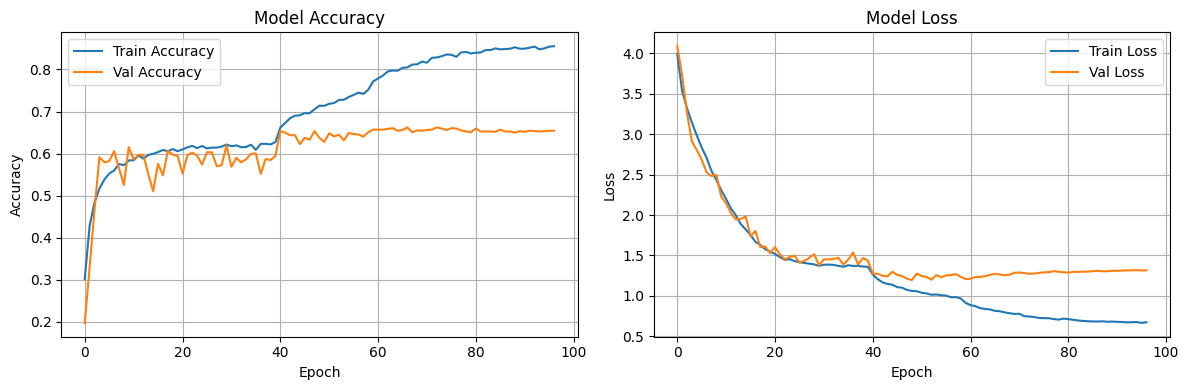

In [ ]:
plot_training_history(history)

In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder):
    print("\n" + "="*50)
    print("STEP 7: FINAL EVALUATION")
    print("="*50)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"\n{'='*50}")
    print(f"FINAL TEST ACCURACY: {test_acc*100:.2f}%")
    print(f"FINAL TEST LOSS: {test_loss:.4f}")
    print(f"{'='*50}\n")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix

    print("\nClassification Report:")
    print("="*50)
    print(classification_report(y_test_classes, y_pred_classes,
                                target_names=label_encoder.classes_))

    print("\nConfusion Matrix:")
    print("="*50)
    print(confusion_matrix(y_test_classes, y_pred_classes))
    print("="*50 + "\n")

In [ ]:
evaluate_model(model, X_test, y_test, encoder)


STEP 7: FINAL EVALUATION

FINAL TEST ACCURACY: 65.90%
FINAL TEST LOSS: 1.3004

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.77      0.77       192
     disgust       0.59      0.58      0.59       192
        fear       0.69      0.55      0.62       193
       happy       0.68      0.65      0.67       193
     neutral       0.57      0.75      0.64       170
         sad       0.68      0.66      0.67       192

    accuracy                           0.66      1132
   macro avg       0.66      0.66      0.66      1132
weighted avg       0.66      0.66      0.66      1132


Confusion Matrix:
[[148  16   5  16   3   4]
 [ 15 112   5   9  36  15]
 [  9  19 107  17  14  27]
 [ 17  13  13 126  17   7]
 [  2  14   9  11 127   7]
 [  3  16  15   5  27 126]]



#**Real-time Testing**

*Install Dependencies*

In [ ]:
def setup_audio_recording():
    print("Installing dependencies...")

    # Install system packages
    import subprocess
    subprocess.run(['apt-get', 'update', '-qq'], check=True)
    subprocess.run(['apt-get', 'install', '-y', 'ffmpeg'], check=True)

    # Install Python packages
    subprocess.run(['pip', 'install', '-q', 'ffmpeg-python'], check=True)

    print("✅ All dependencies installed!\n")


*Javascript for recording*

In [ ]:
# This is the EXACT HTML from your original code
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

*Recording audio using microphone*

In [ ]:
def get_audio():
    import ffmpeg

    print("\n" + "="*60)
    print("🎤 AUDIO RECORDING INSTRUCTIONS")
    print("="*60)
    print("1. A button will appear below")
    print("2. Click 'Press to start recording' button")
    print("3. Allow microphone access if prompted")
    print("4. Speak clearly for 2-3 seconds")
    print("5. Click the button AGAIN to stop (it says 'Recording... press to stop')")
    print("6. Wait for 'Saving the recording...' message")
    print("7. Audio player will appear when done")
    print("="*60 + "\n")

    display(HTML(AUDIO_HTML))
    data = eval_js("data")

    # Check if recording was successful
    if not data or data == "0" or data == "undefined":
        raise ValueError("❌ Recording failed! Make sure you clicked the button twice.")

    binary = b64decode(data.split(',')[1])

    process = (ffmpeg
        .input('pipe:0')
        .output('pipe:1', format='wav')
        .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)

    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))

    print("\n✅ Audio recorded successfully!")
    print(f"   Sample rate: {sr} Hz")
    print(f"   Duration: {len(audio)/sr:.2f} seconds\n")

    return audio, sr

*Extracting features from recorded audio*

In [ ]:
def get_features_recorded(data, sr):
    # Get features for recorded audio using microphone
    res1 = extract_features(data, sr)
    result = np.array(res1)

    # Get audio features with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sr)
    result = np.vstack((result, res2))

    # Get audio features with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch_shift(new_data, sr)
    res3 = extract_features(data_stretch_pitch, sr)
    result = np.vstack((result, res3))

    return result

*Real-time testing*

In [ ]:
def test_realtime(encoder):
    start_time = time.time()

    # Load the best model
    res_model = load_model("/content/drive/MyDrive/AudioFiles/emotion_model_final.keras")
    print("✅ Model loaded successfully\n")

    # Record the audio
    audio, sr = get_audio()

    # Save audio in a file
    files = []
    os.makedirs('/content/drive/MyDrive/AudioFiles/realtimetested', exist_ok=True)
    os.chdir('/content/drive/MyDrive/AudioFiles/realtimetested')

    for file in glob.glob("*.npy"):
        files.append(file)

    # Save the audio file for reference
    np.save('/content/drive/MyDrive/AudioFiles/realtimetested/audiorec{}.npy'.format(len(files)), audio)
    print(f"✅ Audio saved as: audiorec{len(files)}.npy")

    # Plot the recorded audio
    plt.figure(figsize=(12, 4))
    plt.plot(audio)
    plt.title("Recorded Audio Waveform", fontsize=14, fontweight='bold')
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save the plot of audio file
    plt.savefig("audiorec{}.png".format(len(files)))
    print(f"✅ Audio plot saved as: audiorec{len(files)}.png\n")

    # Convert int to float
    audio = audio.astype('float')

    # Get audio features from the recorded voice
    print("🔧 Extracting features...")
    feature = get_features_recorded(audio, sr)

    # Apply min max scaling
    scaler = MinMaxScaler()
    feature = scaler.fit_transform(feature)

    # Get the predicted label
    print("🤖 Predicting emotion...\n")
    label = res_model.predict(feature)

    # Convert predictions from one-hot to class indices
    label_indices = np.argmax(label, axis=1)

    # Get the label information by reversing one hot encoded output
    label_predicted = encoder.inverse_transform(label_indices)

    print("\n" + "="*60)
    print("🎭 PREDICTION RESULTS")
    print("="*60)
    print("\nThe Emotion Predicted For Recorded Audio Using Microphone is:")
    print(f"\n    ✨ {label_predicted[0].upper()} ✨\n")

    # Show all predictions
    print("Detailed predictions:")
    aug_types = ['Original audio', 'With noise', 'Stretched + Pitched']
    for i, (pred, aug) in enumerate(zip(label_predicted, aug_types)):
        confidence = np.max(label[i]) * 100
        print(f"  {aug:20s}: {pred:10s} (confidence: {confidence:.2f}%)")

    print("="*60 + "\n")

    # Create a dataframe for recorded audio features
    df = pd.DataFrame(index=range(0, 3), columns=['path', 'label', 'audio'])
    for i in range(0, 3):
        df["path"][i] = '/content/drive/MyDrive/AudioFiles/realtimetested/audiorec{}.npy'.format(len(files))
        df["label"][i] = label_predicted[i]
        df["audio"][i] = feature[i]

    # Store the real time predicted features in a csv file
    csv_path = '/content/drive/MyDrive/AudioFiles/realtimetested/real_time_predicted_audio_features_new.csv'
    df.to_csv(csv_path, mode='a', index=False, header=not os.path.exists(csv_path))
    print(f"✅ Results saved to CSV\n")

    # Calculate execution time
    end_time = time.time()
    print(f"⏱️  Total execution time: {end_time - start_time:.2f} seconds\n")

    return label_predicted[0]

*Evaluating results of recorded audio*

In [ ]:
def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
    start_time = time.time()

    # Load the best model
    model = load_model("/content/drive/MyDrive/AudioFiles/emotion_model_final.keras")

    # Evaluate training accuracy
    print("\n📊 Evaluating model performance...\n")
    _, train_acc = model.evaluate(np.expand_dims(x_train, -1), y_train, batch_size=1, verbose=0)
    # Evaluate testing accuracy
    _, test_acc = model.evaluate(np.expand_dims(x_test, -1), y_test, batch_size=1, verbose=0)
    # Evaluate validation accuracy
    _, val_acc = model.evaluate(np.expand_dims(x_val, -1), y_val, batch_size=1, verbose=0)

    print("\n**********************************************")
    print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100), 2)))
    print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100), 2)))
    print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100), 2)))
    print("************************************************")

    # Predict the outcome of the model
    y_pred = model.predict(np.expand_dims(x_test, -1))
    y_pred = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # View the classification report for test data and predictions
    from sklearn.metrics import classification_report, confusion_matrix

    print("\nClassification report for Emotion Recognition")
    print(classification_report(y_test_classes, y_pred))

    # View confusion matrix for test data and predictions
    print("\nConfusion matrix for Emotion Recognition")
    print(confusion_matrix(y_test_classes, y_pred))
    print("************************************************")

    # Calculate execution time
    end_time = time.time()
    print(f"\n⏱️  Execution time: {end_time - start_time:.2f} seconds\n")


🔧 TROUBLESHOOTING GUIDE

IF RECORDING FAILS:

1. ❌ Button doesn't appear
   → Run: setup_audio_recording()
   → Restart runtime and try again

2. ❌ "IndexError: list index out of range"
   → You didn't click the button the SECOND time to stop
   → The button should change text twice:
     - First click: "Press to start recording" → "Recording... press to stop"
     - Second click: "Recording... press to stop" → "Saving the recording..."

3. ❌ No audio player appears
   → You didn't grant microphone permissions
   → Refresh page and grant permissions when browser asks

4. ❌ Permission denied
   → Click the camera/microphone icon in browser address bar
   → Allow microphone access for colab.research.google.com

5. ❌ Browser issues
   → Use Google Chrome (works best)
   → Clear browser cache
   → Try incognito mode

6. ❌ Still not working
   → Copy this notebook to a new notebook
   → Restart runtime: Runtime → Restart runtime
   → Run all cells fresh from top
    



*Loading encoded features*

In [ ]:
# Option A: Load saved encoder (if you saved it before)
import pickle
try:
    with open("/content/drive/MyDrive/AudioFiles/label_encoder.pkl", 'rb') as f:
        encoder = pickle.load(f)
    print("✅ Encoder loaded from file")
except:
    # Option B: Create from features CSV
    from sklearn.preprocessing import LabelEncoder
    df = pd.read_csv("/content/drive/MyDrive/Split/train_features.csv")
    encoder = LabelEncoder()
    encoder.fit(df['Label'].values)
    print("✅ Encoder created from features")
    print(f"Classes: {encoder.classes_}")

✅ Encoder created from features
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


✅ Model loaded successfully


🎤 AUDIO RECORDING INSTRUCTIONS
1. A button will appear below
2. Click 'Press to start recording' button
3. Allow microphone access if prompted
4. Speak clearly for 2-3 seconds
5. Click the button AGAIN to stop (it says 'Recording... press to stop')
6. Wait for 'Saving the recording...' message
7. Audio player will appear when done




✅ Audio recorded successfully!
   Sample rate: 48000 Hz
   Duration: 8.82 seconds

✅ Audio saved as: audiorec14.npy


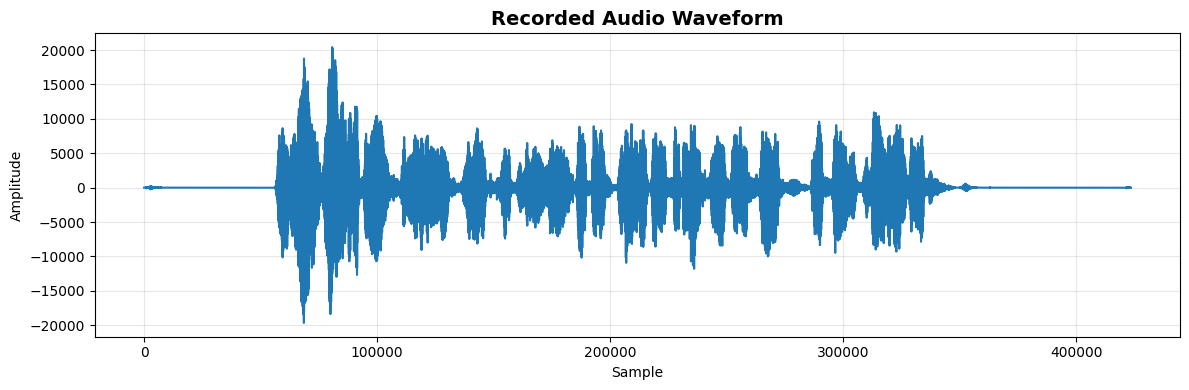

✅ Audio plot saved as: audiorec14.png

🔧 Extracting features...
🤖 Predicting emotion...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step

🎭 PREDICTION RESULTS

The Emotion Predicted For Recorded Audio Using Microphone is:

    ✨ ANGRY ✨

Detailed predictions:
  Original audio      : angry      (confidence: 99.99%)
  With noise          : angry      (confidence: 94.82%)
  Stretched + Pitched : neutral    (confidence: 99.43%)

✅ Results saved to CSV

⏱️  Total execution time: 16.29 seconds



<Figure size 640x480 with 0 Axes>

In [ ]:
predicted_emotion = test_realtime(encoder)